In [1]:
# install pymongo if not installed

! pip install pymongo

In [2]:
from pymongo import MongoClient
import pandas as pd

# connect to local mongodb and database test
 
MONGO_HOST= 'mongodb://localhost:27017/test'

client = MongoClient(MONGO_HOST)

# select database
db=client['test']

#select the collection within the database
collection = db.healthImpact

In [9]:
# disply first document in the collection
result=collection.find()
result[0]

{'_id': ObjectId('6217cd460af6ac5787de0048'),
 'created_at': 'Thu Feb 24 18:24:01 +0000 2022',
 'id': 1496913822854140000,
 'id_str': '1496913822854139908',
 'text': 'RT @DrBrendaMTR: Love this! Sleep is vital for optimal for human health … human health and environmental health are interconnected, sleep m…',
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'truncated': False,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 115105845,
  'id_str': '115105845',
  'name': 'Liz Borkowski',
  'screen_name': 'LizBorkowski',
  'location': 'DC',
  'url': 'http://www.thepumphandle.org/',
  'description': "Public health researcher at George Washington University, managing editor of Women's Health Issues. She/her, views are my own.",
  'translator_type': 'none',
  'protected': False,
  'verified': False,
  'followers_

# conduct a text search

Need to create a index first in Visual studio code


In [7]:
# display top 5 tweets (based on the score of relevence) that mention health problem, not covid
pipeline= [
    {"$match": {"$text": 
        {"$search": "\"health problem\" -covid"}
    }},
    {"$addFields": {"score": {"$meta": "textScore"}}},
    {"$sort": {"score":-1}},
    {"$limit": 5},
    {"$project":{
        "text":1,
        "score":1,
        "created_at":1,
        "_id":0
    }
    }
]

result=collection.aggregate(pipeline)

for res in result:
    print(res)

{'text': 'RT @RickDav41117830: SEC has No Problem , Allowing Big Oil, to LIE about their Part in Climate Change and Health Problems caused by the Ref…', 'created_at': 'Sat Feb 19 20:06:46 +0000 2022', 'score': 1.3833333333333333}
{'text': 'SEC has No Problem , Allowing Big Oil, to LIE about their Part in Climate Change and Health Problems caused by the… https://t.co/VAUtZdFRdn', 'created_at': 'Sat Feb 19 20:03:52 +0000 2022', 'score': 1.375}
{'text': 'RT @BarbaraLawrene: So do I. He was not a child when he first commented on climate change. He has no acknowledgment mental health problem.…', 'created_at': 'Sun Feb 20 15:11:33 +0000 2022', 'score': 1.0909090909090908}
{'text': 'RT @BarbaraLawrene: So do I. He was not a child when he first commented on climate change. He has no acknowledgment mental health problem.…', 'created_at': 'Sun Feb 20 15:03:08 +0000 2022', 'score': 1.0909090909090908}
{'text': 'RT @BarbaraLawrene: So do I. He was not a child when he first commented on climate cha

In [23]:
# find top 10 users based on number of tweets in this topic.
import pandas as pd

pipeline =[
  {"$group": {
    "_id": "$user.screen_name",
    "numTweets": {"$sum":1}
  }
  },
  {"$sort": {"numTweets": -1}},
  {"$limit": 10},
  {"$project": {
   "screenName": "$_id",
   "numTweets":1,
   "_id":0
  }
  }
]

result=collection.aggregate(pipeline)

result_list=[]  # create am array to store the result

for res in result:
        #print(res)
    result_list.append(res)
    
result_list

# convert result into pandas

result_pd = pd.DataFrame(list(result_list))

result_pd.head()

,numTweets,screenName
0,52,JFSebastian146
1,38,glblhlthtwitbot
2,16,jane__eden
3,14,wakeywakey107
4,14,wong52


## [Choose a color palettes in seaborn](https://seaborn.pydata.org/tutorial/color_palettes.html)

<AxesSubplot:xlabel='numTweets', ylabel='screenName'>

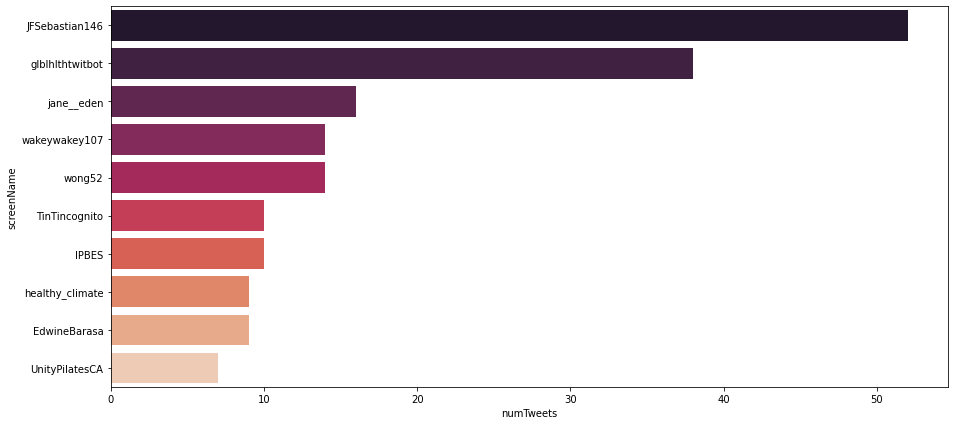

In [53]:
# visualize the result

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set the figure size
plt.figure(figsize=(15, 7))

# use a sequential color with 10 variations
palette=sns.color_palette("rocket", 10)

# plot a bar chart
sns.barplot(
    x="numTweets", 
    y="screenName", 
    data=result_pd, 
    palette=palette)

In [62]:
# define a function to return top N users based on number of tweets
import pandas as pd
def topNUsers(n):
    
    pipeline =[
      {"$group": {
    "_id": "$user.screen_name",
    "numTweets": {"$sum":1}
      }
      },
  {"$sort": {"numTweets": -1}},
  {"$limit": n},
  {"$project": {
   "screenName": "$_id",
   "numTweets":1,
   "_id":0
  }
  }
  ]

    result=collection.aggregate(pipeline)

    result_list=[]  # create am array to store the result

    for res in result:
        #print(res)
        result_list.append(res)
    
    result_pd = pd.DataFrame(list(result_list))
    
    return result_pd

<AxesSubplot:xlabel='numTweets', ylabel='screenName'>

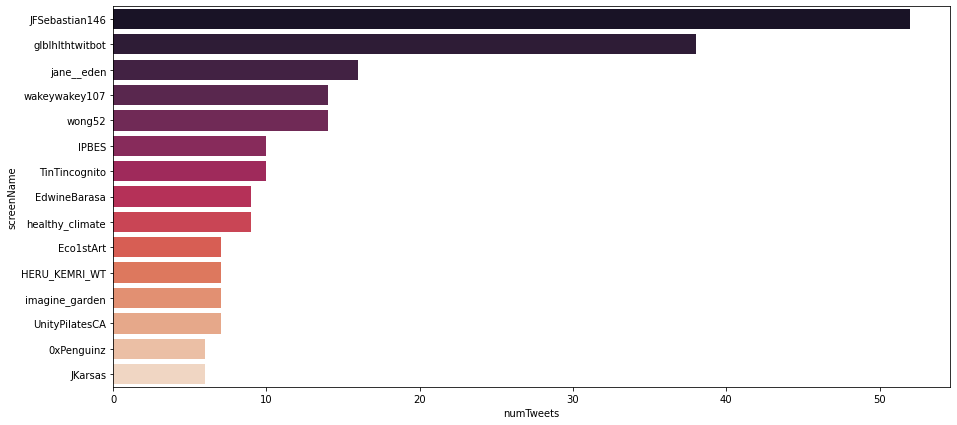

In [64]:
result_pd=topNUsers(15)

# visualize the result

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set the figure size
plt.figure(figsize=(15, 7))

# use a sequential color with 15 variations
palette=sns.color_palette("rocket", 15)

# plot a bar chart
sns.barplot(
    x="numTweets", 
    y="screenName", 
    data=result_pd, 
    palette=palette)

In [80]:
# display top N hashtags

def topNHashtags(n):
    
    pipeline =[
    {"$unwind": "$entities.hashtags"},
    {"$addFields": {"hashtags": {"$toLower": "$entities.hashtags.text"}}},
    {"$match": {"hashtags": {"$nin": ["climatechange", "climatechangeisreal", "globalwarming"]}}},
    {"$group": {
        "_id": {"hashtag": "$hashtags"},
        "frequency": {"$sum":1}
    }},
    {"$sort": {"frequency":-1}},
    {"$limit":n},
    {"$project":{
        "hashtag": "$_id.hashtag",
        "frequency":1,
        "_id":0    }
    }
]
    
    result=collection.aggregate(pipeline)

    result_list=[]  # create am array to store the result

    for res in result:
        #print(res)
        result_list.append(res)
    
    result_pd = pd.DataFrame(list(result_list))
    
    return result_pd

In [81]:
top10hashtags=topNHashtags(10)

top10hashtags

,frequency,hashtag
0,240,health
1,129,climatereport
2,102,breaking
3,101,ipccreport
4,99,ipcc
5,56,environment
6,42,buildbackbetteract
7,41,nature
8,40,food
9,35,travel


<AxesSubplot:xlabel='frequency', ylabel='hashtag'>

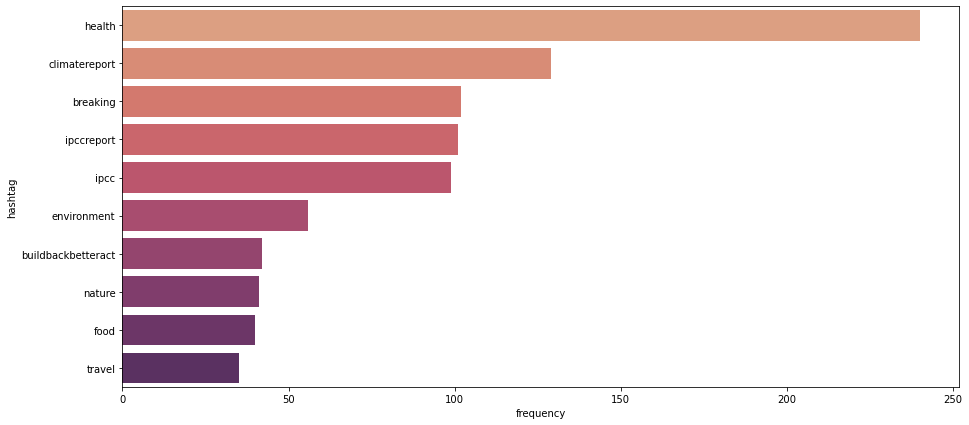

In [82]:
# visualize the result

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set the figure size
plt.figure(figsize=(15, 7))

# use a sequential color with 15 variations
palette=sns.color_palette("flare", 10)

# plot a bar chart
sns.barplot(
    x="frequency", 
    y="hashtag", 
    data=top10hashtags, 
    palette=palette)

In [167]:
# top N hashtags by weekday

def topNHashtagsByWeekday(n):
    pipeline=[
    {"$addFields": {"weekday": {"$dayOfWeek": {"$toDate": "$created_at"}}}},
    {"$unwind": "$entities.hashtags"},
    {"$addFields": {"hashtags": {"$toLower": "$entities.hashtags.text"}}},
    {"$match": {"hashtags": {"$nin": ["climatechange", "climatechangeisreal", "globalwarming"]}}},
    {"$group": {
        "_id": {"weekday": "$weekday", "hashtag":"$hashtags"},
        "frequency": {"$sum":1}
    }},
    {"$sort": {"frequency":-1}},
    {"$group":{
        "_id": "$_id.weekday",
        "hashtags": {"$push": {"hashtag": "$_id.hashtag", "frequency": "$frequency"}}
    }},
    {"$sort": {"_id.weekday":1}},
    {"$project":{
        "top10Hashtags": {"$slice":["$hashtags", 0, n]}
    }},
    {"$unwind": "$top10Hashtags"},
    {"$project":{
        "weekday": "$_id",
        "hashtag": "$top10Hashtags.hashtag",
       "frequency": "$top10Hashtags.frequency",
        "_id":0
    }}    
   ]

    result=collection.aggregate(pipeline)

    result_list=[]  # create am array to store the result

    for res in result:
        #print(res)
        result_list.append(res)
    
    result_pd = pd.DataFrame(list(result_list))
    
    return result_pd

In [168]:
result_pd=topNHashtagsByWeekday(10)
result_pd

,weekday,hashtag,frequency
0,2,climatereport,127
1,2,breaking,101
2,2,ipccreport,98
3,2,ipcc,80
4,2,health,72
...,...,...,...
65,3,ipccreport,3
66,3,africa,3
67,3,fairsharema,2
68,3,mapoli,2


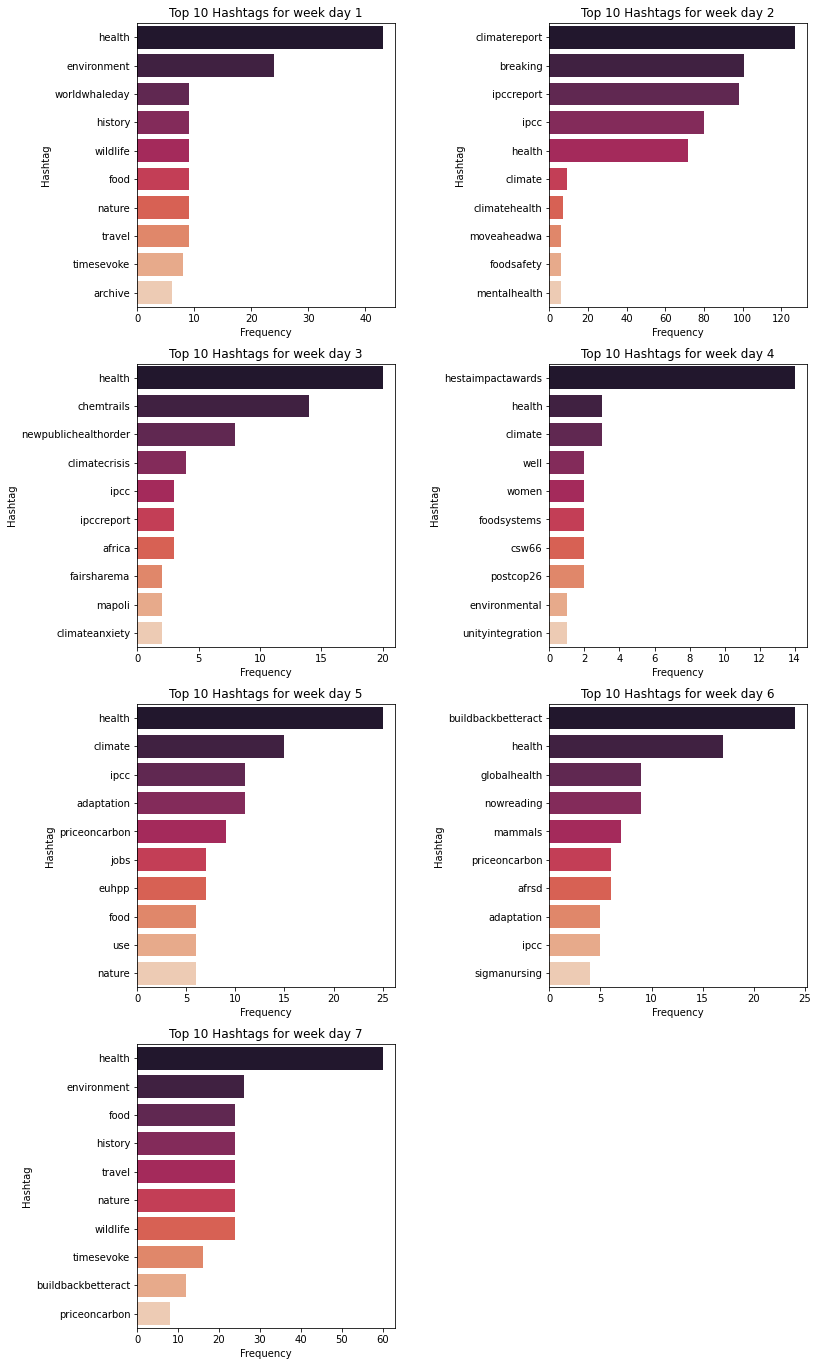

In [172]:
import matplotlib.pyplot as plt
i=1
numWeekdays=result_pd.weekday.unique() #find the unique week days in the result
numWeekdays.sort() #sort the week day by ascending order

fig = plt.figure(figsize=(12,24)) # define the size of the figure
fig.subplots_adjust(hspace=0.2, wspace=0.6)  #adjust the spacing between the plots

for weekday in numWeekdays:
    plt.subplot(4,2,i)   #create a 4 by 2 subplot 
    weekdayResult_pd=result_pd[result_pd["weekday"]==weekday]
    
    # use a sequential color with 10 variations
    palette=sns.color_palette("rocket", 10)

    # plot a bar chart
    sns.barplot( x="frequency", 
    y="hashtag", 
    data=weekdayResult_pd, 
    palette=palette)
    
    # add label
    plt.xlabel('Frequency')
    plt.ylabel("Hashtag")
    plt.title("Top 10 Hashtags for week day "+str(weekday))
    i=i+1

In [83]:
top50hashtags=topNHashtags(50)

top50hashtags

,frequency,hashtag
0,240,health
1,129,climatereport
2,102,breaking
3,101,ipccreport
4,99,ipcc
5,56,environment
6,42,buildbackbetteract
7,41,nature
8,40,food
9,35,travel


In [ ]:
## Visualize top 50 hashtags

In [76]:
# install wordcloud

!pip install wordcloud

In [88]:
# pick top 500 words and convert the result into a dictionary

tophashtags=topNHashtags(50)

result_dict=dict(zip(tophashtags["hashtag"], tophashtags['frequency']))

#result_dict

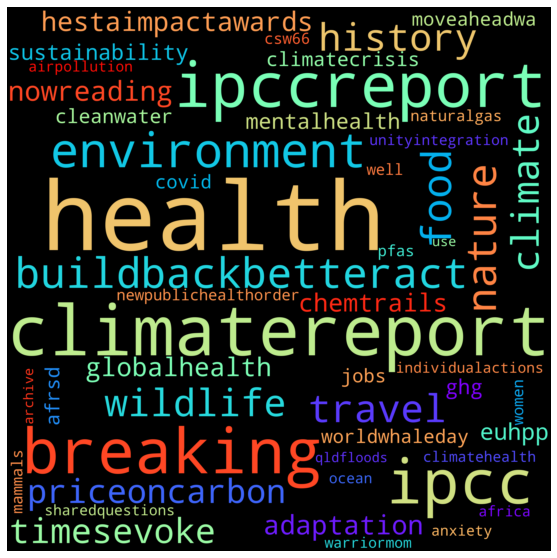

In [87]:
from wordcloud import WordCloud
from PIL import Image

# create the WordCloud object

wordcloud = WordCloud(width=3500,height=3500,normalize_plurals=True, background_color='black',colormap='rainbow')

# generate the word cloud
wordcloud.generate_from_frequencies(result_dict)

#plot
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [94]:
# import stopwords

import nltk
from nltk.corpus import stopwords

stopwords=stopwords.words('english')

In [149]:
# create a function to show top N words by certain key words
def topNWordsByKeyWord(n, keyword):
    
    pipeline=[
    #{"$limit":10000},
    {"$match": {"lang": {"$eq": "en"}}},  # limit language to english
    {"$addFields": {"textArray":{"$toLower": "$text"}}},
    {"$match": {"textArray": {"$regex": keyword}}},
    {"$addFields": {"textArray": {"$split": ["$textArray", " "]}}},
    {"$unwind": "$textArray"},
    {"$addFields": {"textArray":{"$trim": {"input":"$textArray"}}}},
    {"$match": {"textArray": {"$not": {"$regex":"^#"}}}},
    {"$match": {"textArray": {"$not": {"$regex": "^@"}}}},
    {"$match": {"textArray": {"$not": {"$regex":"^http"}}}},
    {"$match": {"textArray": {"$not": {"$regex": "^cov"}}}}, #words not starting with #cov
    {"$addFields": {"textArray": {"$replaceAll": {"input": "$textArray", "find": ":", "replacement": ""}}}},
    {"$addFields": {"textArray": {"$replaceAll": {"input": "$textArray", "find": ".", "replacement": ""}}}},
    {"$addFields": {"textArray": {"$replaceAll": {"input": "$textArray", "find": "-", "replacement": ""}}}},
    {"$addFields": {"textArray": {"$replaceAll": {"input": "$textArray", "find": "…", "replacement": ""}}}},
    {"$addFields": {"textArray": {"$replaceAll": {"input": "$textArray", "find": "&", "replacement": ""}}}},
    {"$addFields": {"textArray": {"$replaceAll": {"input": "$textArray", "find": "'s", "replacement": ""}}}},
    {"$addFields": {"textArray": {"$replaceAll": {"input": "$textArray", "find": ",", "replacement": ""}}}},
    {"$addFields": {"textArray": {"$replaceAll": {"input": "$textArray", "find": ";", "replacement": ""}}}},
    {"$match": {"textArray": {"$nin": ["rt", "", "de", keyword]}}},
    {"$match": {"textArray": {"$nin":stopwords}}},
    {"$group": {
        "_id": "$textArray",
        "frequency": {"$sum":1}
    }},
    {"$sort": {"frequency":-1}},
    {"$limit":n},
    {"$project":{
        "word": "$_id",
        "frequency":1,
        "_id":0    }
    }
    ]

    result=collection.aggregate(pipeline)

    result_list=[]  # create am array to store the result

    for res in result:
        #print(res)
        result_list.append(res)
    
    result_pd = pd.DataFrame(list(result_list))
    
    return result_pd

In [150]:
result_pd=topNWordsByKeyWord(100, "mental health")
result_pd

,frequency,word
0,372,health
1,323,mental
2,247,climate
3,196,change
4,63,crisis
...,...,...
95,8,gas
96,8,children
97,8,child
98,8,commented


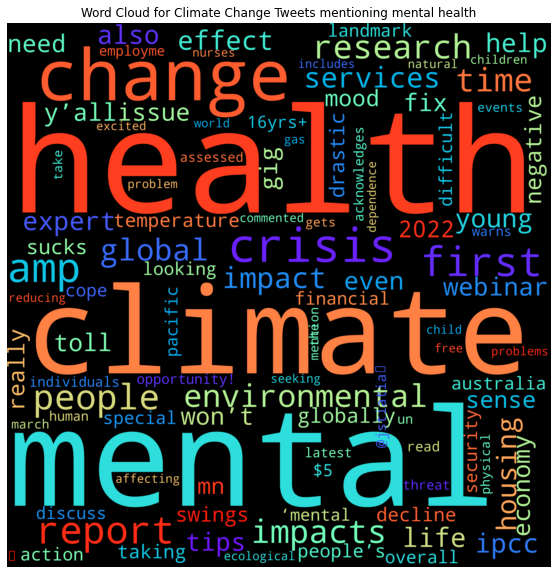

In [154]:
# Word Cloud mentioning mental health
keyword="mental health"

result_pd=topNWordsByKeyWord(100, keyword)

result_dict=dict(zip(result_pd["word"], result_pd['frequency']))

from wordcloud import WordCloud
from PIL import Image

# create the WordCloud object

wordcloud = WordCloud(width=3500,height=3500,normalize_plurals=False, background_color='black',colormap='rainbow')

# generate the word cloud
wordcloud.generate_from_frequencies(result_dict)

#plot
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud for Climate Change Tweets mentioning mental health")
plt.axis('off')
plt.show()

<Figure size 864x864 with 0 Axes>

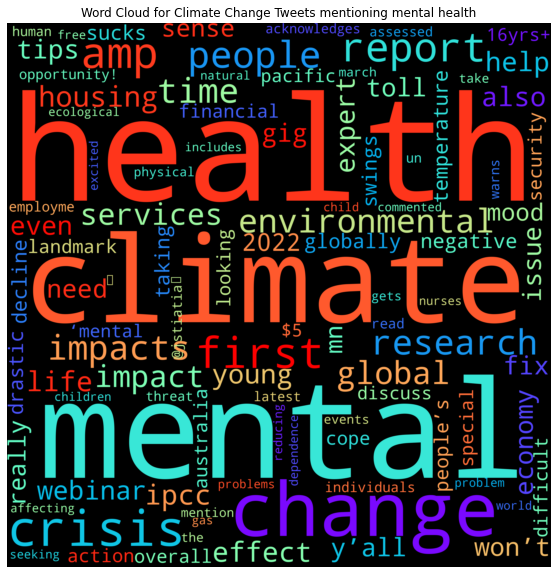

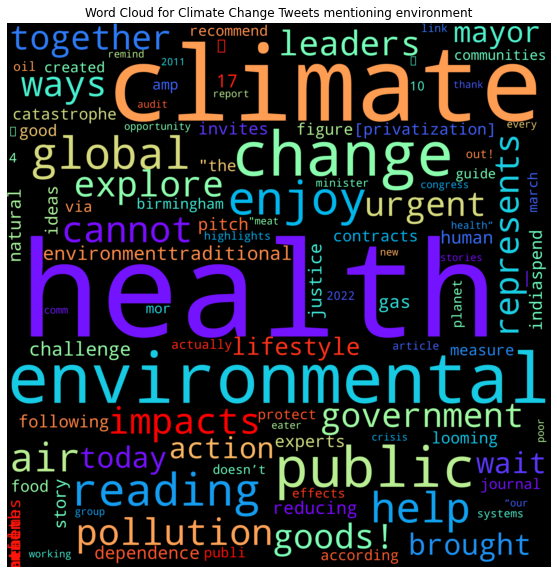

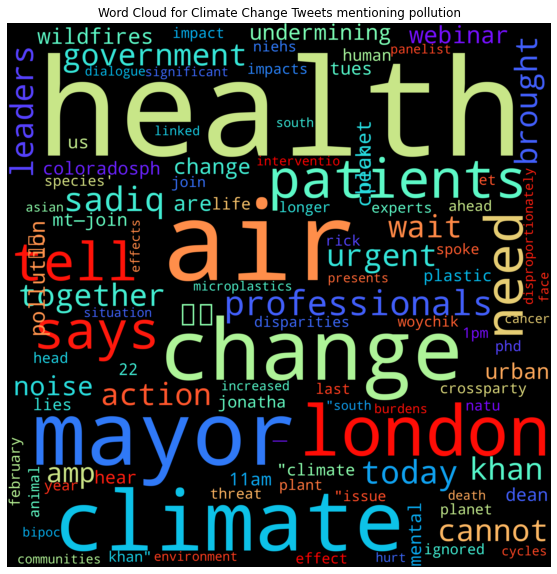

In [152]:
# Word Cloud comparing a few key words:
from wordcloud import WordCloud
from PIL import Image

keywords=['mental health', 'environment', 'pollution']
result_dict_list=[]
i=1

for keyword in keywords:
    result_pd=topNWordsByKeyWord(100, keyword)
    result_dict=dict(zip(result_pd["word"], result_pd['frequency']))
    result_dict_list.append(result_dict)
   

# create the WordCloud object
# create the WordCloud object

wordcloud = WordCloud(width=3500,height=3500,normalize_plurals=False, background_color='black',colormap='rainbow')


fig = plt.figure(figsize=(12,12)) # define the size of the figure
fig.subplots_adjust(hspace=0.2, wspace=0.6)  #adjust the spacing between the plots

j=0
for keyword in keywords:
    #plt.subplot(2,2,j+1)   #create a 4 by 2 subplot 
    wordcloud.generate_from_frequencies(result_dict_list[j])
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title("Word Cloud for Climate Change Tweets mentioning "+keyword)
    plt.axis('off')
    plt.show()
    j=j+1